In [2]:
#importing libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
import librosa.display
from keras import models
from keras import layers
from keras import Input, backend, Model
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten, GRU
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import TimeDistributed
from tensorflow.keras import backend

from keras import regularizers



In [3]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [4]:
songname = '/content/drive/MyDrive/Drive/Data/genres/blues/blues.00000.wav'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [5]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir('/content/drive/MyDrive/Drive/Data/genres/' + genre):
        songname = os.path.join('/content/drive/MyDrive/Drive/Data/genres', genre, filename)
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append((ps, genre_number))



In [6]:
print(len(dataset))

13986


In [7]:
import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))

In [8]:
len(X_train)
X_train.shape
n_features = X_train.shape[2]
input_shape = (None, X_train.shape[1])
print(input_shape)
model_input = Input(input_shape, name='input')
print(model_input)
X_train.shape

(None, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")


(10000, 64, 173, 1)

In [9]:
model = Sequential()

model.add(Conv2D(20, (5, 5), input_shape=(64, 173, 1),
                 activation="relu", strides=1, padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(50, (5, 5), use_bias=50))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation="relu"))
model.add(Lambda(lambda x: backend.expand_dims(x, axis=-1)))
model.add(LSTM(512, activation="relu", return_sequences=False))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 169, 20)       520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 84, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 80, 50)        25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 40, 50)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 26000)             0         
                                                                 
 dense (Dense)               (None, 20)                5

In [10]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr = 1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
history = model.fit(X_train, Y_train, epochs=90, batch_size=64, validation_data= (X_test, Y_test), callbacks=[early_stopping])

Epoch 1/90
157/157 [==============================] - 20s 64ms/step - loss: 2.2763 - accuracy: 0.0982 - val_loss: 2.2112 - val_accuracy: 0.1143
Epoch 2/90
157/157 [==============================] - 9s 57ms/step - loss: 2.1665 - accuracy: 0.1367 - val_loss: 2.1067 - val_accuracy: 0.1828
Epoch 3/90
157/157 [==============================] - 7s 47ms/step - loss: 2.0433 - accuracy: 0.2140 - val_loss: 2.0001 - val_accuracy: 0.2487
Epoch 4/90
157/157 [==============================] - 9s 60ms/step - loss: 1.9216 - accuracy: 0.2700 - val_loss: 1.8781 - val_accuracy: 0.3122
Epoch 5/90
157/157 [==============================] - 7s 46ms/step - loss: 1.8106 - accuracy: 0.3362 - val_loss: 1.7318 - val_accuracy: 0.3691
Epoch 6/90
157/157 [==============================] - 9s 60ms/step - loss: 1.6876 - accuracy: 0.3914 - val_loss: 1.6677 - val_accuracy: 0.3882
Epoch 7/90
157/157 [==============================] - 9s 58ms/step - loss: 1.5950 - accuracy: 0.4268 - val_loss: 1.5864 - val_accuracy: 0.417

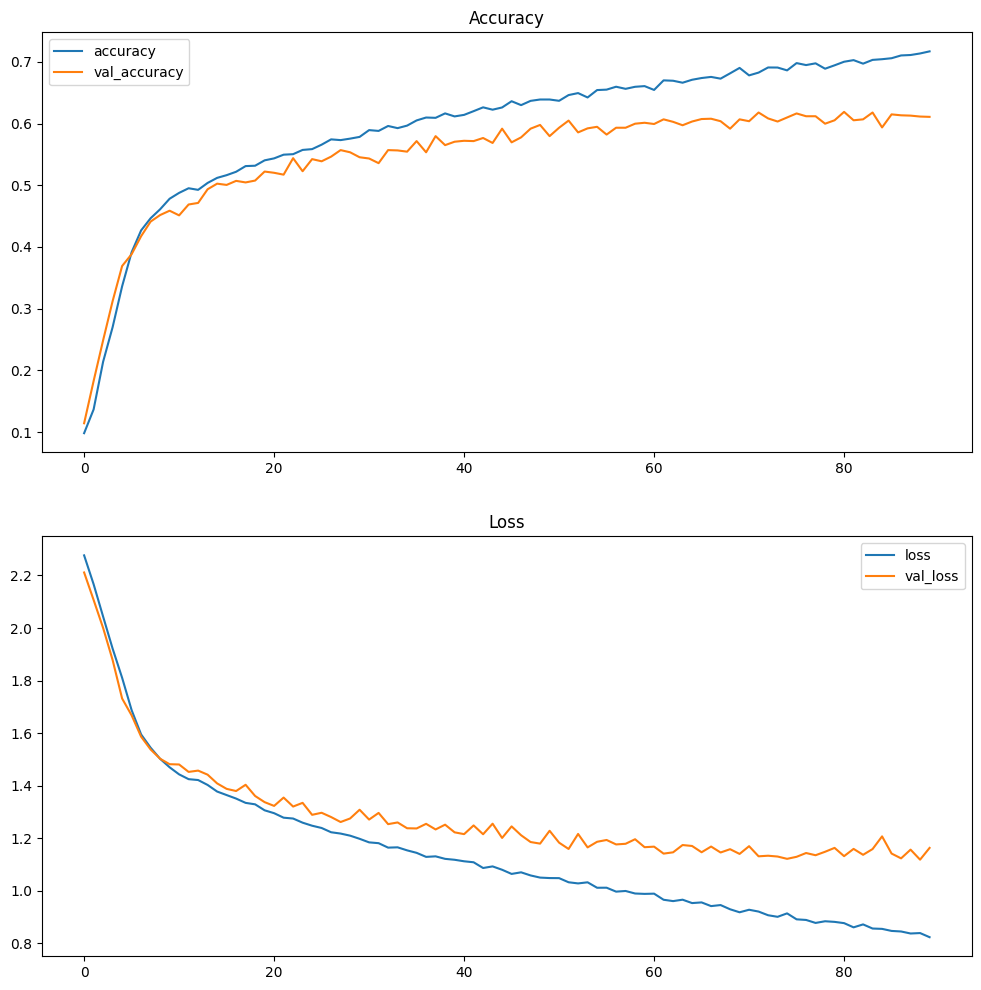

313/313 - 2s - loss: 0.8353 - accuracy: 0.7061 - 2s/epoch - 7ms/step
63/63 - 0s - loss: 1.1633 - accuracy: 0.6108 - 333ms/epoch - 5ms/step
Training accuracy: 0.7060999870300293
Test accuracy: 0.6107754111289978


In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(12, 12))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].legend(['accuracy','val_accuracy'])
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].legend(['loss','val_loss'])
axs[1].set_title('Loss')


plt.show()

train_loss, train_acc = model.evaluate(X_train, Y_train, verbose = 2)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc)


In [14]:
# Importing libraries
from sklearn.metrics import classification_report, accuracy_score

# Training data
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_true = np.argmax(Y_train, axis=1)

print("Training Results:")
print("Accuracy Score:", accuracy_score(train_true, train_predictions))
print(classification_report(train_true, train_predictions))

# Test data
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_true = np.argmax(Y_test, axis=1)

print("Test Results:")
print("Accuracy Score:", accuracy_score(test_true, test_predictions))
print(classification_report(test_true, test_predictions))



313/313 [==============================] - 3s 11ms/step
Training Results:
Accuracy Score: 0.7061
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      1002
           1       0.82      0.94      0.88      1001
           2       0.72      0.55      0.62      1003
           3       0.75      0.58      0.65       984
           4       0.68      0.83      0.75      1001
           5       0.72      0.59      0.65       968
           6       0.91      0.85      0.88      1030
           7       0.79      0.79      0.79      1010
           8       0.57      0.65      0.61      1000
           9       0.65      0.49      0.56      1001

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.72      0.71      0.70     10000

63/63 [==============================] - 0s 6ms/step
Test Results:
Accuracy Score: 0.6107754279959718
              precision    recall  f1-scor

References: 
Music Genre Recognition: https://github.com/EsratMaria/MusicGenreRecogniton 